# THAI data analysis (work in progress)

In [1]:
# Standard library
from pathlib import Path

# Data analysis and viz libraries
import dask.array as da
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# Local modules
from calc import (
    hdiv,
    integral,
    mass_weighted_vertical_integral,
    moist_static_energy,
    vert_mer_mean_of_mse_flux,
)
from grid import (
    EARTH_RADIUS,
    meridional_mean,
    reverse_along_dim,
    roll_da_to_0360,
    roll_da_to_pm180,
    zonal_mean,
)
from model_exocam import adjust_exocam_grid, calc_alt_exocam, calc_pres_exocam
from model_rocke3d import adjust_rocke3d_grid
from model_um import adjust_um_grid, calc_um_ocean_frac, open_mf_um, prep_um_ds

Define a common THAI directory

In [3]:
thai_dir = Path.cwd().parent / "data"

Create a dicitonary with model metadata

In [4]:
models = {
    "LMDG": {
        "dir": thai_dir / "LMD-G",
        "chunks": {"Time": 61},
        "time": "Time",
        "lon": "longitude",
        "lat": "latitude",
        "lev": "altitude",
    },
    "UM": {
        "dir": thai_dir / "UM",
        "chunks": {"hourly": 61},
        "time": "hourly",
        "lon": "longitude_t",
        "lat": "latitude_t",
        "lev": "thlev_zsea_theta",
    },
    "ExoCAM": {
        "dir": thai_dir / "ExoCAM",
        "chunks": {"time": 61},
        "time": "time",
        "lon": "lon",
        "lat": "lat",
        "lev": "lev",
    },
    "ROCKE3D": {
        "dir": thai_dir / "ROCKE3D",
        "chunks": {"time": 50},  # ROCKE3D has 2500 time steps
        "time": "time",
        "lon": "lon",
        "lat": "lat",
        "lev": "level",
    },
}

## Constants

Define atmospheric and planetary constants. Note the planet's radius is in meters!

In [5]:
# # Contants
# from aeolus.const import init_const
# c = init_const("trap1e")
# r_planet = c.radius.data
# gas_const = c.dry_air_gas_constant.data
# c_p = c.dry_air_spec_heat_press.data
# g = c.gravity.data
# l_v = c.condensible_heat_vaporization.data
# TRAPPIST-1e INPUT PARAMETERS
# THAI_Case: Ben1, Ben2, Hab1, Hab1star, Hab2
THAI_case = "Ben2"

itime = 2440  # time step dry cases

# ATMOSPHERIC COMPOSITIONS
Ptot = 1  # sufrace pressure in bar

if THAI_case in ["Ben1", "Hab1", "Hab1_star"]:
    CO2 = 0.000400  # mixing ratio of CO2 in bar
    N2 = 1 - CO2  # mixing ratio of N2 in bar
    cp = 1039
    Rcp = 0.297
    rgas = 287.058  # J/kg K
elif THAI_case in ["Ben2", "Hab2"]:  # Ben2 and Hab2
    CO2 = 1.0  # mixing ratio of CO2
    N2 = 1.0 - CO2  # mixing ratio of N2
    cp = 846
    Rcp = 0.189
    rgas = 188.92  # J/kg K
rvapor = 461.52  # J/kg K
mw_dryair = 28.0134 * N2 + 44.01 * CO2  # Atmospheric molecular weight [g/mol]
mw_vapor = 18.01528
mw_ratio = mw_dryair / mw_vapor
latent_heat = 2_501_000

# PLANETS PROPERTIES
Planet_Dfactor = (
    0.940  # Earth unit, following Khane et al. 2018 from Delrez et al. 2018
)
Planet_gfactor = 0.930  # Earth unit

Earth_D = 6371 * 2 * 1e3  # Earth diameter [m]
Earth_g = 9.81  # Earth gravity
gplanet = Planet_gfactor * Earth_g  # gravity of the planet in m/s2
Dplanet = int(Planet_Dfactor * Earth_D)  # Diameter of the planet in km
Rplanet = Dplanet / 2

## Loading the data

Lazily load all data into one dictionary.

In [6]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
# Loop over THAI cases (this loop can swapped places with the loop below if needed)
for THAI_case in [THAI_case]:
    # for each of the THAI cases, create a nested directory for models
    datasets[THAI_case] = {}
    for model_key, model_dict in models.items():
        if model_key == "UM":
            files = sorted(
                (models[model_key]["dir"]).glob(f"{THAI_case}_{model_key}*.nc")
            )
            ds = open_mf_um(
                files,
                main_time="hourly",
                rad_time="hourly_rad",
                decode_times=False,
                chunks=model_dict["chunks"],
            )
            ds = prep_um_ds(ds, vert_lev_miss_val="drop")

        elif model_key == "ROCKE3D":
            ds = xr.open_mfdataset(
                str(model_dict["dir"] / f"{THAI_case}_{model_key}_*.nc"),
                decode_times=False,
                chunks=model_dict["chunks"],
            )
            _tmp_ds = {}
            for d in ds.data_vars:
                _tmp_ds[d] = adjust_rocke3d_grid(ds[d])
            ds = xr.Dataset(_tmp_ds)  # OUTSIDE THE LOOP!

        elif model_key == "ExoCAM":
            ds = xr.open_mfdataset(
                str(model_dict["dir"] / f"{THAI_case}_{model_key}*.nc"),
                decode_times=False,
                combine="nested",
                concat_dim=model_dict["time"],
                chunks=model_dict["chunks"],
            )
            _tmp_ds = {}
            for d in ds.data_vars:
                _tmp_ds[d] = adjust_exocam_grid(ds[d])
            ds = xr.Dataset(_tmp_ds)

        elif model_key == "LMDG":
            ds = xr.open_mfdataset(
                str(model_dict["dir"] / f"{THAI_case}_{model_key}*.nc"),
                decode_times=False,
                combine="nested",
                concat_dim=model_dict["time"],
                chunks=model_dict["chunks"],
            )
        datasets[THAI_case][model_key] = ds
del ds

## Diagnostics and plots

### ExoCAM

In [7]:
# Prepare variables
model_key = "ExoCAM"
ds = datasets[THAI_case][model_key].isel(
    **{
        # Choose only the last chunk for now
        models[model_key]["time"]: slice(-61, None),
        # Discard rows close to poles
        models[model_key]["lat"]: slice(1, -1),
        # (Optional, change 2nd None to turn it on) Discard upper atmosphere levels
        models[model_key]["lev"]: slice(None, None),
        "ilev": slice(None, None),
    }
)
temp_ExoCAM = ds.T
press_ExoCAM = calc_pres_exocam(ds)
rho_ExoCAM = press_ExoCAM / (rgas * temp_ExoCAM)
u_ExoCAM = ds.U
v_ExoCAM = ds.V
q_ExoCAM = ds.Q
alt_ExoCAM = calc_alt_exocam(
    ds,
    mw_ratio=mw_ratio,
    dry_air_gas_constant=rgas,
    condens_gas_constant=rvapor,
    gravity=gplanet,
)

In [8]:
(dse_hdiv_int_by_press,) = vert_mer_mean_of_mse_flux(
    u_ExoCAM,
    v_ExoCAM,
    temp=temp_ExoCAM,
    alt=alt_ExoCAM,
    zcoord=press_ExoCAM,
    zcoord_type="pressure",
    lon_name=models[model_key]["lon"],
    lat_name=models[model_key]["lat"],
    z_name=models[model_key]["lev"],
    cmpnt="dry",
    c_p=cp,
    gravity=gplanet,
    latent_heat=latent_heat,
    r_planet=Rplanet,
)

In [9]:
(dse_hdiv_int_by_height,) = vert_mer_mean_of_mse_flux(
    u_ExoCAM,
    v_ExoCAM,
    temp=temp_ExoCAM,
    alt=alt_ExoCAM,
    zcoord=alt_ExoCAM,
    rho=rho_ExoCAM,
    zcoord_type="height",
    lon_name=models[model_key]["lon"],
    lat_name=models[model_key]["lat"],
    z_name=models[model_key]["lev"],
    cmpnt="dry",
    c_p=cp,
    gravity=gplanet,
    latent_heat=latent_heat,
    r_planet=Rplanet,
)

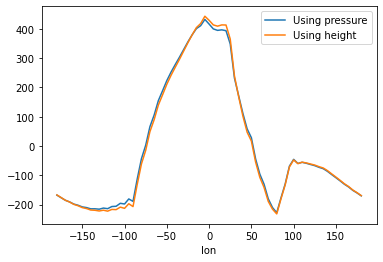

In [10]:
dse_hdiv_int_by_height.mean("time").plot(label="Using pressure")
dse_hdiv_int_by_press.mean("time").plot(label="Using height")
plt.legend()

## ROCKE3D

In [11]:
model_key = "ROCKE3D"
ds = datasets[THAI_case][model_key].isel(
    **{
        # Choose only the last chunk for now
        models[model_key]["time"]: slice(None, None),
        # Discard rows close to poles
        models[model_key]["lat"]: slice(1, -1),
        # Discard upper atmosphere levels
        models[model_key]["lev"]: slice(None, None),
    }
)
lat_ROCKE3D = ds.lat
lon_ROCKE3D = ds.lon
tsurf_ROCKE3D = ds.tgrnd + 273.15  # temperature in C
ps_ROCKE3D = ds.p_surf


temp_ROCKE3D = ds.t
u_ROCKE3D = ds.u
v_ROCKE3D = ds.v
w_ROCKE3D = ds.w
alt_ROCKE3D = ds.z
press_ROCKE3D = ds.p_3d * 100  # (mb to Pa)
rho_ROCKE3D = press_ROCKE3D / (rgas * temp_ROCKE3D)

In [12]:
(dse_hdiv_int_ROCKE3D,) = vert_mer_mean_of_mse_flux(
    u_ROCKE3D,
    v_ROCKE3D,
    temp=temp_ROCKE3D,
    alt=alt_ROCKE3D,
    zcoord=alt_ROCKE3D,
    rho=rho_ROCKE3D,
    zcoord_type="height",
    lon_name=models[model_key]["lon"],
    lat_name=models[model_key]["lat"],
    z_name=models[model_key]["lev"],
    cmpnt="dry",
    c_p=cp,
    gravity=gplanet,
    latent_heat=latent_heat,
    r_planet=Rplanet,
)

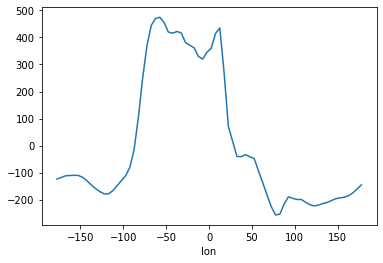

In [13]:
dse_hdiv_int_ROCKE3D.mean(models[model_key]["time"]).plot()

### UM

In [14]:
# Prepare variables
model_key = "UM"
ds = datasets[THAI_case][model_key].isel(
    **{
        # Choose only the last chunk for now
        models[model_key]["time"]: slice(None, None),
        # Discard rows close to poles
        models[model_key]["lat"]: slice(1, -1),
        # Discard upper atmosphere levels
        #         models[model_key]["lev"]: slice(None, -5),
    }
)
temp_UM = ds.STASH_m01s16i004
u_UM = ds.STASH_m01s00i002
v_UM = ds.STASH_m01s00i003
press_UM = ds.STASH_m01s00i408
# q_UM = ds.STASH_m01s00i010
alt_UM = ds.thlev_zsea_theta
rho_UM = press_UM / (rgas * temp_UM)

In [15]:
(dse_hdiv_int_UM,) = vert_mer_mean_of_mse_flux(
    u_UM,
    v_UM,
    temp=temp_UM,
    alt=alt_UM,
    rho=rho_UM,
    zcoord_type="height",
    lon_name=models[model_key]["lon"],
    lat_name=models[model_key]["lat"],
    z_name=models[model_key]["lev"],
    cmpnt="dry",
    c_p=cp,
    gravity=gplanet,
    latent_heat=latent_heat,
    r_planet=Rplanet,
)

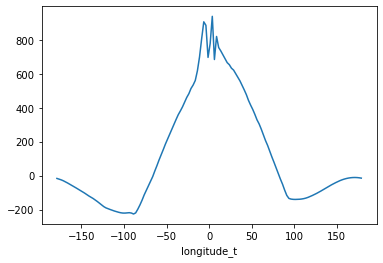

In [16]:
dse_hdiv_int_UM.mean(models[model_key]["time"]).plot()